In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Desktop/SLR-to-BI-4750`


In [2]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting
using DataFrames
# using Measures
# using MarkdownTables
using XLSX
using CSV
using Dates
using StatsModels
using GLM
using KernelDensity
using StatsBase


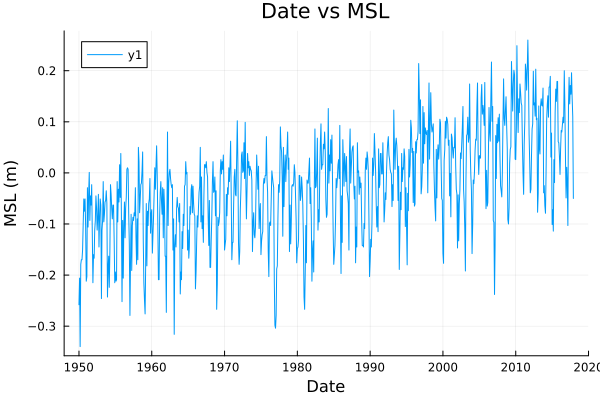

In [3]:
history = CSV.read("data/CO-OPS_8518750_met.csv", DataFrame)

history.Date = Date.(history.Date, "yyyy/mm/dd")  
rename!(history, Symbol("MSL (m)") => :MSL)
plot(history.Date, history."MSL", xlabel="Date", ylabel="MSL (m)", title="Date vs MSL", 
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2020, 1, 1)), string.(1950:10:2020)))

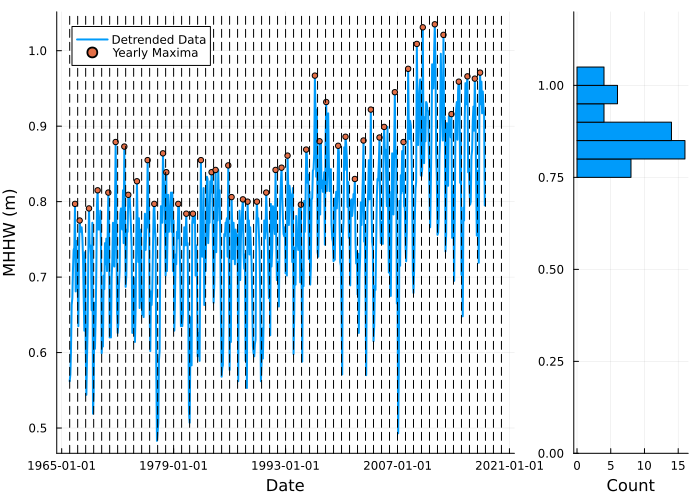

In [35]:
# this code was adapted from https://viveks.me/simulation-data-analysis/slides/lecture04-1.html#/example-peaks-over-threshold
dat = CSV.read("data/CO-OPS_8518750_met.csv", DataFrame)

dat.Date = DateTime.(dat.Date, dateformat"yyyy/mm/dd")

rename!(dat, Symbol("MHHW (m)") => :weather)

dat = filter(row -> !isnan(row.weather), dat)

dat.Year = year.(dat.Date)

max_dat = combine(groupby(dat, :Year)) do subdf
    max_row = subdf[argmax(subdf.weather), :]
    return (Date = max_row.Date, weather = max_row.weather)
end

p1 = plot(
    dat.Date, 
    dat.weather; 
    ylabel = "MHHW (m)", 
    label = "Detrended Data", 
    linewidth = 2, 
    legend = :topleft, 
    xlabel = "Date"
)

scatter!(p1, max_dat.Date, max_dat.weather, label = "Yearly Maxima", markersize = 3)


year_start = Date(year(first(dat.Date)), 1, 1):Year(1):Date(2020, 1, 1)
# year_start = Date(1950, 1, 1):Year(1):Date(2020, 1, 1)

vline!(p1, DateTime.(year_start), color = :black, label = false, linestyle = :dash)

yearly_maxima = max_dat.weather
yearly_maxima_df = DataFrame(
    Year = 1:length(yearly_maxima),  
    MaxValue = yearly_maxima         
)

max_values = yearly_maxima_df.MaxValue

p2 = histogram(
    max_values,
    bins=10,
    orientation=:horizontal, 
    xlabel="Count",       
    legend=false,             
    ylims=(0, 1.2)        
)


l = @layout [a{0.8w} b{0.2w}]
plot(p1, p2, layout=l, size=(700, 500))


In [36]:
mean(max_values)

0.8719807692307692

In [ ]:
p2 = histogram(
    max_values,
    bins=10,
    orientation=:horizontal,
    xlabel="Count",
    legend=false,
    ylims=(-0.4, 0.3),  # Adjust or remove ylims if inappropriate
    xlims=(minimum(max_values)-0.1, maximum(max_values)+0.1)  # Ensure valid range
)


[0.797, 0.775, 0.791, 0.815, 0.812, 0.879, 0.873, 0.809, 0.827, 0.855, 0.797, 0.864, 0.839, 0.797, 0.784, 0.784, 0.855, 0.839, 0.842, 0.848, 0.806, 0.803, 0.8, 0.8, 0.812, 0.842, 0.845, 0.861, 0.796, 0.869, 0.967, 0.88, 0.932, 0.874, 0.886, 0.83, 0.881, 0.922, 0.885, 0.899, 0.945, 0.879, 0.976, 1.009, 1.031, 1.035, 1.021, 0.916, 0.959, 0.966, 0.963, 0.971]


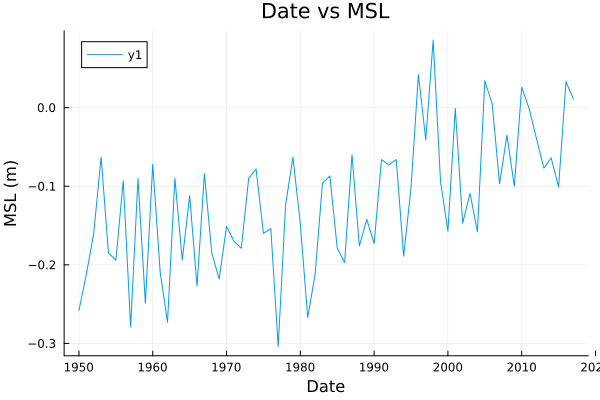

In [5]:
history_simple = select(history, :Date, :("MSL"))
decades_df = filter(row -> month(row.Date) == 1 && day(row.Date) == 1, history_simple)
plot(decades_df.Date, decades_df."MSL", xlabel="Date", ylabel="MSL (m)", title="Date vs MSL", 
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2020, 1, 1)), string.(1950:10:2020)))

In [4]:
function nmc(distribution, data, year)
    samples = rand(distribution, 1000)
    new_date = Date("$year-01-01")  
    new_row = (Date = new_date, MSL = mean(samples))
    
    data = push!(data, new_row)
    return data

end

nmc (generic function with 1 method)

In [5]:
function add_mean_std(df::DataFrame, cols::Vector{Symbol})
    df.mean = [mean([row[c] for c in cols]) for row in eachrow(df)]
    df.std = [std([row[c] for c in cols]) for row in eachrow(df)]
    
    return df
end

function mix_distributions(df::DataFrame, weights::Vector{Float64})
    # Ensure the number of weights matches the number of rows in the DataFrame
    if length(weights) != nrow(df)
        error("Number of weights must match the number of rows in the DataFrame.")
    end
    
    means = df.mean
    stds = df.std
    
    # create a vector of Normal distributions
    distributions = [Normal(mean, std) for (mean, std) in zip(means, stds)]
    
    # mix the model
    mixture_model = MixtureModel(distributions, weights)

    return mixture_model
end

mix_distributions (generic function with 1 method)

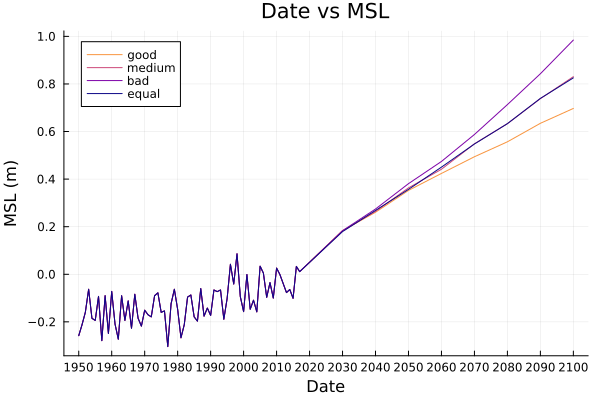

In [12]:
# get slr data

slr = DataFrame(XLSX.readtable("data/ipcc_ar6_sea_level_projection_psmsl_id_12.xlsx", "Total"))

scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp585"]

years = 2020:10:2150

# make dataframe slr_df

years_all = []
scenarios_all = []
quantile_17_all = []
quantile_50_all = []
quantile_83_all = []

for scenario in scenarios
    data_25 = filter(row -> row.scenario == scenario && row.quantile == 17, slr)
    data_50 = filter(row -> row.scenario == scenario && row.quantile == 50, slr)
    data_75 = filter(row -> row.scenario == scenario && row.quantile == 83, slr)

    sea_levels_25 = Vector{Float64}(data_25[1, Symbol.(string.(years))])
    sea_levels_50 = Vector{Float64}(data_50[1, Symbol.(string.(years))])
    sea_levels_75 = Vector{Float64}(data_75[1, Symbol.(string.(years))])

    append!(years_all, years)
    append!(scenarios_all, fill(scenario, length(years)))
    append!(quantile_17_all, sea_levels_25)
    append!(quantile_50_all, sea_levels_50)
    append!(quantile_83_all, sea_levels_75)
end

slr_df = DataFrame(
    Year = years_all,
    Scenario = scenarios_all,
    Quantile_17 = quantile_17_all,
    Quantile_50 = quantile_50_all,
    Quantile_83 = quantile_83_all
)

# break slr_df up per projection decade

slr_2030_df = slr_df[slr_df.Year .== 2030, :]
slr_2040_df = slr_df[slr_df.Year .== 2040, :]
slr_2050_df = slr_df[slr_df.Year .== 2050, :]
slr_2060_df = slr_df[slr_df.Year .== 2060, :]
slr_2070_df = slr_df[slr_df.Year .== 2070, :]
slr_2080_df = slr_df[slr_df.Year .== 2080, :]
slr_2090_df = slr_df[slr_df.Year .== 2090, :]
slr_2100_df = slr_df[slr_df.Year .== 2100, :]

# add uncertainity quantiles

slr_2030_df = add_mean_std(slr_2030_df, [:Quantile_17, :Quantile_50, :Quantile_83])

slr_2040_df = add_mean_std(slr_2040_df, [:Quantile_17, :Quantile_50, :Quantile_83])

slr_2050_df = add_mean_std(slr_2050_df, [:Quantile_17, :Quantile_50, :Quantile_83])

slr_2060_df = add_mean_std(slr_2060_df, [:Quantile_17, :Quantile_50, :Quantile_83])

slr_2070_df = add_mean_std(slr_2070_df, [:Quantile_17, :Quantile_50, :Quantile_83])

slr_2080_df = add_mean_std(slr_2080_df, [:Quantile_17, :Quantile_50, :Quantile_83])

slr_2090_df = add_mean_std(slr_2090_df, [:Quantile_17, :Quantile_50, :Quantile_83])

slr_2100_df = add_mean_std(slr_2100_df, [:Quantile_17, :Quantile_50, :Quantile_83])

# define weights

weights_good = [3/5, 1/5, 0.5/5, 0.25/5, 0.25/5]
weights_med = [0.25/5, 0.75/5, 3/5, 0.75/5, 0.25/5]
weights_bad = [0.25/5, 0.25/5, 0.5/5, 1/5, 3/5]
weights_eq = [1/5, 1/5, 1/5, 1/5, 1/5]

# make distributions based on weights and decades 

# 2030
# good
mixture_model_2030_good = mix_distributions(slr_2030_df, weights_good)
# medium
mixture_model_2030_med = mix_distributions(slr_2030_df, weights_med)
# bad
mixture_model_2030_bad = mix_distributions(slr_2030_df, weights_bad)
# weights_eq
mixture_model_2030_eq = mix_distributions(slr_2030_df, weights_eq)

# 2040 gmbe
# good
mixture_model_2040_good = mix_distributions(slr_2040_df, weights_good)
# medium
mixture_model_2040_med = mix_distributions(slr_2040_df, weights_med)
# bad
mixture_model_2040_bad = mix_distributions(slr_2040_df, weights_bad)
# weights_eq
mixture_model_2040_eq = mix_distributions(slr_2040_df, weights_eq)

# 2050 gmbe
# good
mixture_model_2050_good = mix_distributions(slr_2050_df, weights_good)
# medium
mixture_model_2050_med = mix_distributions(slr_2050_df, weights_med)
# bad
mixture_model_2050_bad = mix_distributions(slr_2050_df, weights_bad)
# weights_eq
mixture_model_2050_eq = mix_distributions(slr_2050_df, weights_eq)

# 2060 gmbe
# good
mixture_model_2060_good = mix_distributions(slr_2060_df, weights_good)
# medium
mixture_model_2060_med = mix_distributions(slr_2060_df, weights_med)
# bad
mixture_model_2060_bad = mix_distributions(slr_2060_df, weights_bad)
# weights_eq
mixture_model_2060_eq = mix_distributions(slr_2060_df, weights_eq)

# 2070 gmbe
# good
mixture_model_2070_good = mix_distributions(slr_2070_df, weights_good)
# medium
mixture_model_2070_med = mix_distributions(slr_2070_df, weights_med)
# bad
mixture_model_2070_bad = mix_distributions(slr_2070_df, weights_bad)
# weights_eq
mixture_model_2070_eq = mix_distributions(slr_2070_df, weights_eq)

# 2080 gmbe
# good
mixture_model_2080_good = mix_distributions(slr_2080_df, weights_good)
# medium
mixture_model_2080_med = mix_distributions(slr_2080_df, weights_med)
# bad
mixture_model_2080_bad = mix_distributions(slr_2080_df, weights_bad)
# weights_eq
mixture_model_2080_eq = mix_distributions(slr_2080_df, weights_eq)

# 2090 gmbe
# good
mixture_model_2090_good = mix_distributions(slr_2090_df, weights_good)
# medium
mixture_model_2090_med = mix_distributions(slr_2090_df, weights_med)
# bad
mixture_model_2090_bad = mix_distributions(slr_2090_df, weights_bad)
# weights_eq
mixture_model_2090_eq = mix_distributions(slr_2090_df, weights_eq)

# 2100 gmbe
# good
mixture_model_2100_good = mix_distributions(slr_2100_df, weights_good)
# medium
mixture_model_2100_med = mix_distributions(slr_2100_df, weights_med)
# bad
mixture_model_2100_bad = mix_distributions(slr_2100_df, weights_bad)
# weights_eq
mixture_model_2100_eq = mix_distributions(slr_2100_df, weights_eq)

# now we add these for final data

history = CSV.read("data/CO-OPS_8518750_met.csv", DataFrame)

history.Date = Date.(history.Date, "yyyy/mm/dd")  
rename!(history, Symbol("MSL (m)") => :MSL)
plot(history.Date, history."MSL", xlabel="Date", ylabel="MSL (m)", title="Date vs MSL", 
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2020, 1, 1)), string.(1950:10:2020)))
history_simple = select(history, :Date, :("MSL"))
decades_df = filter(row -> month(row.Date) == 1 && day(row.Date) == 1, history_simple)
plot(decades_df.Date, decades_df."MSL", xlabel="Date", ylabel="MSL (m)", title="Date vs MSL", 
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2020, 1, 1)), string.(1950:10:2020)))
decades_df_good = filter(row -> month(row.Date) == 1 && day(row.Date) == 1, history_simple)
decades_df_med = filter(row -> month(row.Date) == 1 && day(row.Date) == 1, history_simple)
decades_df_bad = filter(row -> month(row.Date) == 1 && day(row.Date) == 1, history_simple)
decades_df_eq = filter(row -> month(row.Date) == 1 && day(row.Date) == 1, history_simple);

decades_df_good = nmc(mixture_model_2030_good, decades_df_good, 2030)
decades_df_good = nmc(mixture_model_2040_good, decades_df_good, 2040)
decades_df_good = nmc(mixture_model_2050_good, decades_df_good, 2050)
decades_df_good = nmc(mixture_model_2060_good, decades_df_good, 2060)
decades_df_good = nmc(mixture_model_2070_good, decades_df_good, 2070)
decades_df_good = nmc(mixture_model_2080_good, decades_df_good, 2080)
decades_df_good = nmc(mixture_model_2090_good, decades_df_good, 2090)
decades_df_good = nmc(mixture_model_2100_good, decades_df_good, 2100);

decades_df_med = nmc(mixture_model_2030_med, decades_df_med, 2030)
decades_df_med = nmc(mixture_model_2040_med, decades_df_med, 2040)
decades_df_med = nmc(mixture_model_2050_med, decades_df_med, 2050)
decades_df_med = nmc(mixture_model_2060_med, decades_df_med, 2060)
decades_df_med = nmc(mixture_model_2070_med, decades_df_med, 2070)
decades_df_med = nmc(mixture_model_2080_med, decades_df_med, 2080)
decades_df_med = nmc(mixture_model_2090_med, decades_df_med, 2090)
decades_df_med = nmc(mixture_model_2100_med, decades_df_med, 2100);

decades_df_bad = nmc(mixture_model_2030_bad, decades_df_bad, 2030)
decades_df_bad = nmc(mixture_model_2040_bad, decades_df_bad, 2040)
decades_df_bad = nmc(mixture_model_2050_bad, decades_df_bad, 2050)
decades_df_bad = nmc(mixture_model_2060_bad, decades_df_bad, 2060)
decades_df_bad = nmc(mixture_model_2070_bad, decades_df_bad, 2070)
decades_df_bad = nmc(mixture_model_2080_bad, decades_df_bad, 2080)
decades_df_bad = nmc(mixture_model_2090_bad, decades_df_bad, 2090)
decades_df_bad = nmc(mixture_model_2100_bad, decades_df_bad, 2100);

decades_df_eq = nmc(mixture_model_2030_eq, decades_df_eq, 2030)
decades_df_eq = nmc(mixture_model_2040_eq, decades_df_eq, 2040)
decades_df_eq = nmc(mixture_model_2050_eq, decades_df_eq, 2050)
decades_df_eq = nmc(mixture_model_2060_eq, decades_df_eq, 2060)
decades_df_eq = nmc(mixture_model_2070_eq, decades_df_eq, 2070)
decades_df_eq = nmc(mixture_model_2080_eq, decades_df_eq, 2080)
decades_df_eq = nmc(mixture_model_2090_eq, decades_df_eq, 2090)
decades_df_eq = nmc(mixture_model_2100_eq, decades_df_eq, 2100);

colors = ["#f89540", "#cc4778", "#7e03a8", "#0d0887"]

plot(decades_df_good.Date, decades_df_good."MSL", xlabel="Date", ylabel="MSL (m)", label = "good", title="Date vs MSL", color = colors[1],
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2100, 1, 1)), string.(1950:10:2100)))
plot!(decades_df_med.Date, decades_df_med."MSL", xlabel="Date", ylabel="MSL (m)", label = "medium", title="Date vs MSL", color = colors[2],
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2100, 1, 1)), string.(1950:10:2100)))
plot!(decades_df_bad.Date, decades_df_bad."MSL", xlabel="Date", ylabel="MSL (m)", label = "bad", title="Date vs MSL", color = colors[3],
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2100, 1, 1)), string.(1950:10:2100)))
plot!(decades_df_eq.Date, decades_df_eq."MSL", xlabel="Date", ylabel="MSL (m)", label = "equal", title="Date vs MSL", color = colors[4],
    xticks=(collect(Date(1950, 1, 1):Year(10):Date(2100, 1, 1)), string.(1950:10:2100)))


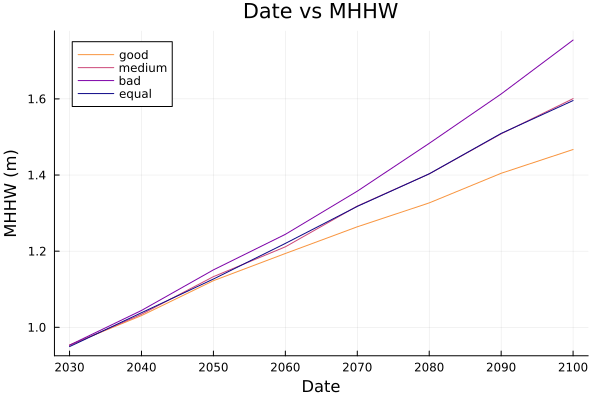

In [13]:
# Shift all "MSL" values by 0.77 m
decades_df_good."MSL" .+= 0.77
decades_df_med."MSL" .+= 0.77
decades_df_bad."MSL" .+= 0.77
decades_df_eq."MSL" .+= 0.77

decades_df_good = filter(row -> row.Date >= Date(2030, 1, 1), decades_df_good)
decades_df_med = filter(row -> row.Date >= Date(2030, 1, 1), decades_df_med)
decades_df_bad = filter(row -> row.Date >= Date(2030, 1, 1), decades_df_bad)
decades_df_eq = filter(row -> row.Date >= Date(2030, 1, 1), decades_df_eq)

# Define the new xticks starting at 2020
xticks_range = collect(Date(2030, 1, 1):Year(10):Date(2100, 1, 1))
xticks_labels = string.(2030:10:2100)

plot(decades_df_good.Date, decades_df_good."MSL", xlabel="Date", ylabel="MHHW (m)", label="good", title="Date vs MHHW", color = colors[1],
     xticks=(collect(Date(2030, 1, 1):Year(10):Date(2100, 1, 1)), string.(2030:10:2100)))

plot!(decades_df_med.Date, decades_df_med."MSL", xlabel="Date", ylabel="MHHW (m)", label="medium", title="Date vs MHHW", color = colors[2],
      xticks=(collect(Date(2030, 1, 1):Year(10):Date(2100, 1, 1)), string.(2030:10:2100)))

plot!(decades_df_bad.Date, decades_df_bad."MSL", xlabel="Date", ylabel="MHHW (m)", label="bad", title="Date vs MHHW", color = colors[3],
      xticks=(collect(Date(2030, 1, 1):Year(10):Date(2100, 1, 1)), string.(2030:10:2100)))

plot!(decades_df_eq.Date, decades_df_eq."MSL", xlabel="Date", ylabel="MHHW (m)", label="equal", title="Date vs MHHW", color = colors[4],
      xticks=(collect(Date(2030, 1, 1):Year(10):Date(2100, 1, 1)), string.(2030:10:2100)))


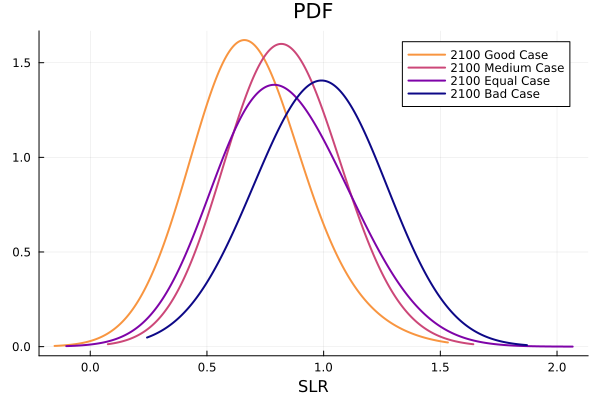

In [16]:
samples = rand(mixture_model_2100_good, 1000)
colors = ["#f89540", "#cc4778", "#7e03a8", "#0d0887"]
    
# Create a range of values for the x-axis (for plotting the PDF)
x_range = range(minimum(samples), stop=maximum(samples), length=1000)
    
# Calculate the PDF for the mixture model at each x value
pdf_values = pdf(mixture_model_2100_good, x_range)
    

samples_b = rand(mixture_model_2100_bad, 1000)
    
# Create a range of values for the x-axis (for plotting the PDF)
x_range_b = range(minimum(samples_b), stop=maximum(samples_b), length=1000)
    
# Calculate the PDF for the mixture model at each x value
pdf_values_b = pdf(mixture_model_2100_bad, x_range_b)

samples_c = rand(mixture_model_2100_med, 1000)
    
# Create a range of values for the x-axis (for plotting the PDF)
x_range_c = range(minimum(samples_c), stop=maximum(samples_c), length=1000)
    
# Calculate the PDF for the mixture model at each x value
pdf_values_c = pdf(mixture_model_2100_med, x_range_c)
    

samples_d = rand(mixture_model_2100_eq, 1000)
    
# Create a range of values for the x-axis (for plotting the PDF)
x_range_d = range(minimum(samples_d), stop=maximum(samples_d), length=1000)
    
# Calculate the PDF for the mixture model at each x value
pdf_values_d = pdf(mixture_model_2100_eq, x_range_d)


# Plot the PDF
plot(x_range, pdf_values, color = colors[1], xlabel="SLR", label="2100 Good Case", title="PDF",lw=2)
# Plot the PDF
plot!(x_range_c, pdf_values_c, color = colors[2], xlabel="SLR",  label="2100 Medium Case", lw=2)
plot!(x_range_d, pdf_values_d, color = colors[3], xlabel="SLR",  label="2100 Equal Case", lw=2)
plot!(x_range_b, pdf_values_b, color = colors[4], xlabel="SLR",  label="2100 Bad Case", lw=2)

In [20]:
# Filter each DataFrame to get the row where the date is in the year 2100
good_2100 = decades_df_good[decades_df_good.Date .== Date(2100, 1, 1), :]
med_2100 = decades_df_med[decades_df_med.Date .== Date(2100, 1, 1), :]
bad_2100 = decades_df_bad[decades_df_bad.Date .== Date(2100, 1, 1), :]
eq_2100 = decades_df_eq[decades_df_eq.Date .== Date(2100, 1, 1), :]

# Extract the "MSL" values for the year 2100
good_msl_2100 = good_2100."MSL"[1]
med_msl_2100 = med_2100."MSL"[1]
bad_msl_2100 = bad_2100."MSL"[1]
eq_msl_2100 = eq_2100."MSL"[1]

# Print the results
println("Good scenario MSL in 2100: $good_msl_2100")
println("Medium scenario MSL in 2100: $med_msl_2100")
println("Bad scenario MSL in 2100: $bad_msl_2100")
println("Equal scenario MSL in 2100: $eq_msl_2100")


Good scenario MSL in 2100: 1.4509835636121085
Medium scenario MSL in 2100: 1.6022040686109544
Bad scenario MSL in 2100: 1.7424743273611834
Equal scenario MSL in 2100: 1.595886968984919
